###This IPython Notebook is for performing a fit and generating a figure of the spectrum of sample VG03.

The filename of the figure is **VG03_f100.pdf**.

Author: Michael Gully-Santiago, `gully@astro.as.utexas.edu`

Date: January 13, 2015

In [1]:
%pylab inline
import emcee
import triangle
import pandas as pd
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [2]:
sns.set_context("paper", font_scale=2.0, rc={"lines.linewidth": 2.5})
sns.set(style="ticks")

Read in the data.  We want "VG03_pos1"

In [3]:
df = pd.read_csv('../data/cln_20130218_cary5000.csv', index_col=0)
df = df[df.index > 1250.0]

Import all the local models, saved locally as `etalon.py`.  See the paper for derivations of these equations.

In [4]:
from etalon import *
np.random.seed(78704) #My old zip code

In [5]:
# Introduce the Real data
x = df.index.values
N = len(x)
# Define T_DSP for the model
T_DSP = T_gap_Si(x, 0.0)
n1 = sellmeier_Si(x)

# Define uncertainty
yerr = 0.0002*np.ones(N)
iid_cov = np.diag(yerr ** 2)

# Select the spectrum of interest
# Normalize the spectrum by measured DSP Si wafer.
y = df.VG03_pos1/df.VG06

Define the likelihood.

In [6]:
def lnlike(d, f, lna, lns):
    a, s = np.exp(lna), np.exp(lns)
    off_diag_terms = a**2 * np.exp(-0.5 * (x[:, None] - x[None, :])**2 / s**2)
    C = iid_cov + off_diag_terms
    sgn, logdet = np.linalg.slogdet(C)
    if sgn <= 0:
        return -np.inf
    r = y - T_gap_Si_withFF_fast(x, d, f, n1)/T_DSP
    return -0.5 * (np.dot(r, np.linalg.solve(C, r)) + logdet)

Define the prior.

In [7]:
def lnprior(d, f, lna, lns):
    if not (3800 < d < 4100 and 0.0 < f < 1.0 and -12 < lna < -2 and 0 < lns < 10):
        return -np.inf
    return 0.0

Combine likelihood and prior to obtain the posterior.

In [8]:
def lnprob(p):
    lp = lnprior(*p)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(*p)

Set up `emcee`.

In [9]:
ndim, nwalkers = 4, 32
d_Guess = 3967.0
f_Guess = 0.995
p0 = np.array([d_Guess, f_Guess, np.log(0.0016), np.log(25.0)])
pos = [p0 + 1.0e-2*p0 * np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

Run the burn-in phase.

In [10]:
pos, lp, state = sampler.run_mcmc(pos, 200)

Run the full MCMC.

In [11]:
sampler.reset()
pos, lp, state = sampler.run_mcmc(pos, 600)
chain = sampler.chain

Inspect the chain.

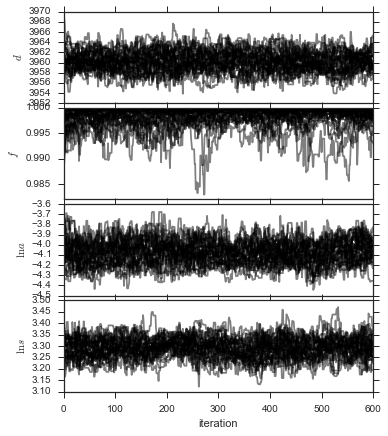

In [12]:
fig, axes = plt.subplots(4, 1, figsize=(5, 6), sharex=True)
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.96, top=0.98,
                    wspace=0.0, hspace=0.05)
[a.plot(np.arange(chain.shape[1]), chain[:, :, i].T, "k", alpha=0.5)
 for i, a in enumerate(axes)]
[a.set_ylabel("${0}$".format(l)) for a, l in zip(axes, ["d", "f", "\ln a", "\ln s"])]
axes[-1].set_xlim(0, chain.shape[1])
axes[-1].set_xlabel("iteration");

Linearize $a$ and $s$ for graphical purposes.

In [13]:
samples_lin = copy(sampler.flatchain)
samples_lin[:, 2:] = np.exp(samples_lin[:, 2:])

Make a triangle corner plot.

Quantiles:
[(0.16, 3958.3891179118996), (0.84, 3962.1133887010574)]
Quantiles:
[(0.16, 0.9970866992659535), (0.84, 0.99972090907362532)]
Quantiles:
[(0.16, 0.015156166651402677), (0.84, 0.018865452024665382)]
Quantiles:
[(0.16, 25.797504873857704), (0.84, 28.035273012311926)]


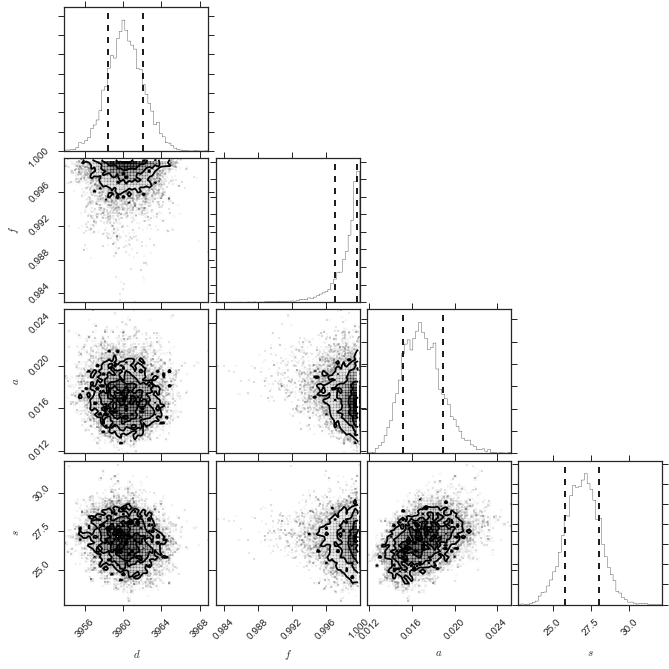

In [14]:
fig = triangle.corner(samples_lin, 
                      labels=map("${0}$".format, ["d", "f", "a", "s"]), 
                      quantiles=[0.16, 0.84])

Quantiles:
[(0.16, 3958.3891179118996), (0.84, 3962.1133887010574)]
Quantiles:
[(0.16, 0.9970866992659535), (0.84, 0.99972090907362532)]


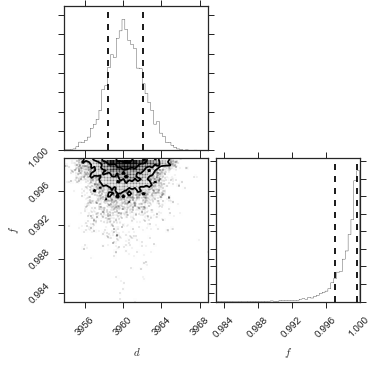

In [15]:
fig = triangle.corner(samples_lin[:,0:2], 
                      labels=map("${0}$".format, ["d", "f"]), 
                      quantiles=[0.16, 0.84])
plt.savefig("VG03_corner.pdf")

Calculate confidence intervals.

In [16]:
d_mcmc, f_mcmc, a_mcmc, s_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples_lin, [16, 50, 84],
                                                axis=0)))
d_mcmc, f_mcmc, a_mcmc, s_mcmc

((3960.1823545036796, 1.9310341973778122, 1.7932365917799871),
 (0.99896558032231486, 0.00075532875131045785, 0.0018788810563613589),
 (0.016877082754201453, 0.0019883692704639293, 0.0017209161027987759),
 (26.937342431642367, 1.0979305806695585, 1.1398375577846629))

In [17]:
print "{:.0f}^{{+{:.0f}}}_{{-{:.0f}}}".format(*d_mcmc)
print "{:.3f}^{{+{:.3f}}}_{{-{:.3f}}}".format(*f_mcmc)

3960^{+2}_{-2}
0.999^{+0.001}_{-0.002}


Overlay draws from the Gaussian Process.

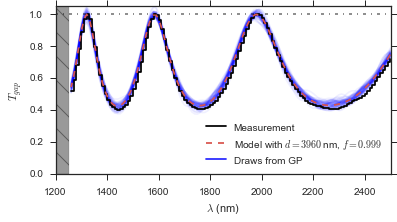

In [18]:
plt.figure(figsize=(6,3))

for d, f, a, s in samples_lin[np.random.randint(len(samples_lin), size=60)]:
    off_diag_terms = a**2 * np.exp(-0.5 * (x[:, None] - x[None, :])**2 / s**2)
    C = iid_cov + off_diag_terms
    fit = T_gap_Si_withFF_fast(x, d, f, n1)/T_DSP
    vec = np.random.multivariate_normal(fit, C)
    plt.plot(x, vec,"-b", alpha=0.06)

plt.step(x, y,color="k", label='Measurement')
fit = T_gap_Si_withFF_fast(x, d_mcmc[0], f_mcmc[0], n1)/T_DSP
fit_label = 'Model with $d={:.0f}$ nm, $f={:.3f}$'.format(d_mcmc[0], f_mcmc[0])
plt.plot(x, fit, '--', color=sns.xkcd_rgb["pale red"], alpha=1.0, label=fit_label)
plt.plot([-10, -9], [-10, -9],"-b", alpha=0.85, label='Draws from GP')
plt.plot([0, 5000], [1.0, 1.0], '-.k', alpha=0.5)
plt.fill_between([1200, 1250], 2.0, 0.0, hatch='\\', alpha=0.4, color='k', label='Si absorption cutoff')

plt.xlabel('$\lambda$ (nm)');
plt.ylabel('$T_{gap}$');
plt.xlim(1200, 2501);
plt.ylim(0.0, 1.05);
plt.legend(loc='lower right')
plt.savefig("VG03_f100_alt.pdf",  bbox_inches='tight')

The end.

In [19]:
sns.set_context('talk', font_scale=1.3)

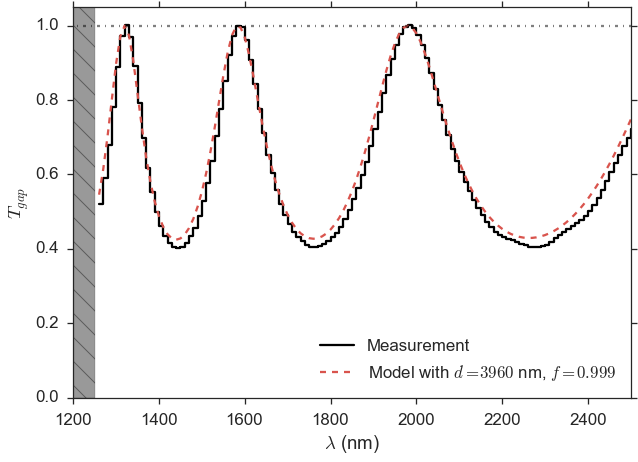

In [20]:
plt.figure(figsize=(10,7))

for d, f, a, s in samples_lin[np.random.randint(len(samples_lin), size=60)]:
    off_diag_terms = a**2 * np.exp(-0.5 * (x[:, None] - x[None, :])**2 / s**2)
    C = iid_cov + off_diag_terms
    fit = T_gap_Si_withFF_fast(x, d, f, n1)/T_DSP
    vec = np.random.multivariate_normal(fit, C)
    #plt.plot(x, vec,"-b", alpha=0.06)

plt.step(x, y,color="k", label='Measurement')
fit = T_gap_Si_withFF_fast(x, d_mcmc[0], f_mcmc[0], n1)/T_DSP

fit_label = 'Model with $d={:.0f}$ nm, $f={:.3f}$'.format(d_mcmc[0], f_mcmc[0])
plt.plot(x, fit, '--', color=sns.xkcd_rgb["pale red"], alpha=1.0, label=fit_label)
#plt.plot([-10, -9], [-10, -9],"-b", alpha=0.85, label='Draws from GP')
plt.plot([0, 5000], [1.0, 1.0], '-.k', alpha=0.5)
plt.fill_between([1200, 1250], 2.0, 0.0, hatch='\\', alpha=0.4, color='k', label='Si absorption cutoff')

plt.xlabel('$\lambda$ (nm)');
plt.ylabel('$T_{gap}$');
plt.xlim(1200, 2501);
plt.ylim(0.0, 1.05);
plt.legend(loc='lower right')
plt.savefig("VG03_f100_data.jpg",  bbox_inches='tight')

In [22]:
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!
